# 6 图像空间滤波

## 卷积

图像可以用函数 $f$ 表示 ($f(x,y)$ 为点 $(x,y)$ 的颜色值), 假设 $w$ 是另一个函数, 定义
$$f*w = \sum f(x-a,y-b)w(a,b)$$
称为卷积 (convolution).

在实际的(离散的)运用中, $w$ 常常只在一个有限的正方形格点上取值, 形成一个矩阵, 称为卷积核 (convolution kernel / filter).

### 空间互相关

$$f*w = \sum f(x+a,y+b)w(a,b)$$
称为空间互相关 (spatial correlation).

In [61]:
import numpy as np
def Convolution(img, kernel, uint8 = True):
    """Apply convolution on an image. The length of kernel should be odd"""
    img2 = np.zeros_like(img, dtype='float')
    img = np.pad(img, kernel.shape[0]//2, mode='edge').astype('float')
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            img2 += kernel[i,j] * img[kernel.shape[0]-1-i:kernel.shape[0]-1-i+img2.shape[0],
                                      kernel.shape[1]-1-j:kernel.shape[1]-1-j+img2.shape[1]]
    if uint8: return np.round(img2).clip(0,255).astype('uint8')
    return img2

x = np.zeros((5,5))
x[2,2] = 1
Convolution(x, np.array([1,2,3,4,5,6,7,8,9.]).reshape((3,3)))

array([[0, 0, 0, 0, 0],
       [0, 1, 2, 3, 0],
       [0, 4, 5, 6, 0],
       [0, 7, 8, 9, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

In [19]:
import numpy as np
def SpatialCorrelation(img, kernel, uint8 = True):
    """Apply spatial correlation on an image. The length of kernel should be odd"""
    img2 = np.zeros_like(img, dtype='float')
    img = np.pad(img, kernel.shape[0]//2, mode='edge').astype('float')
    for i in range(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            img2 += kernel[i,j] * img[i:i+img2.shape[0], j:j+img2.shape[1]]
    if uint8: return np.round(img2).clip(0,255).astype('uint8')
    return img2

x = np.zeros((5,5))
x[2,2] = 1
# See the difference between convolution and spatial correlation
# the latter rotates the kernel by 180°
SpatialCorrelation(x, np.array([1,2,3,4,5,6,7,8,9.]).reshape((3,3)))

array([[0, 0, 0, 0, 0],
       [0, 9, 8, 7, 0],
       [0, 6, 5, 4, 0],
       [0, 3, 2, 1, 0],
       [0, 0, 0, 0, 0]], dtype=uint8)

## 平滑

取 $w(a,b)$ 为如下, 则该卷积对卷积核内部取平均值, 起到平滑 (smoothing) 的作用. 即每个像素取周围 $N^2$ 个点的平均值, 称为平均卷积核 (average kernel).

$$w(a,b)=\left\{\begin{array}{ll}\frac{1}{N^2} & (a,b)\in [0,N)\times [0,N)
\\ 0 & {\rm otherwise}\end{array}\right.$$

<br>

类似地, 如果


$$w(a,b)=\left\{\begin{array}{ll}Ke^{-\frac{(x-N/2)^2+(y-N/2)^2}{2\sigma^2}} & (a,b)\in [0,N)\times [0,N)
\\ 0 & {\rm otherwise}\end{array}\right.$$

其中 $K$ 使得 $\sum_{a,b}w(a,b)=1$, 则称为高斯卷积核 (Gaussian kernel).

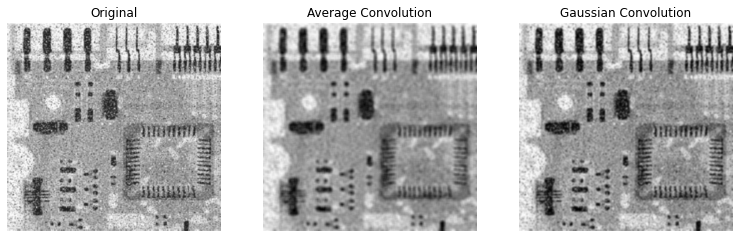

In [3]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

average_kernel = lambda x: np.full((x, x), 1. / (x*x))
def gaussian_kernel(x, var = 1):
    ker = np.meshgrid(np.arange(-(x//2),x//2+1),np.arange(-(x//2),x//2+1))
    ker = np.exp((np.square(ker[0]) + np.square(ker[1])) * (- .5 / var))
    return ker / ker.sum() # normalize

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\chip.png')).convert('L'))
img_avg_conv = Convolution(img, average_kernel(9))
img_gauss_conv = Convolution(img, gaussian_kernel(9, var = 2.5))
plt.figure(figsize = (13, 8))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(img_avg_conv, cmap = 'gray')
plt.axis('off')
plt.title('Average Convolution')
plt.subplot(1,3,3)
plt.imshow(img_gauss_conv, cmap = 'gray')
plt.axis('off')
plt.title('Gaussian Convolution')
plt.show()

也可以定义中值核 (median filter), 每个像素取周围 $N^2$ 个点的.

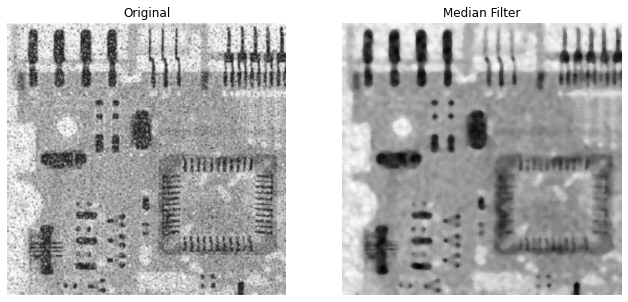

In [4]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

from numba import njit 
@njit
def MedianFilter(img, N):
    """TODO: Use Z-update for faster implementation."""
    img2 = img.copy()
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img2[i,j] = np.median(img[max(i-N//2,0):min(i+N//2+1,img.shape[0]),
                                      max(j-N//2,0):min(j+N//2+1,img.shape[1])])
    return img2

    
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\chip.png')).convert('L'))
img_median = MedianFilter(img, 11)
plt.figure(figsize = (11, 7))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255)
plt.axis('off')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(img_median, cmap = 'gray')
plt.axis('off')
plt.title('Median Filter')
plt.show()

## 边缘

图像的边缘 (edge) 是像素值变动很大的地方, 大致可以分为三种: 突变的 (step edge), 渐变的 (ramp edge), 变一下又变回来的 (peak edge).

这些边缘的地方, 像素值的导数很大.


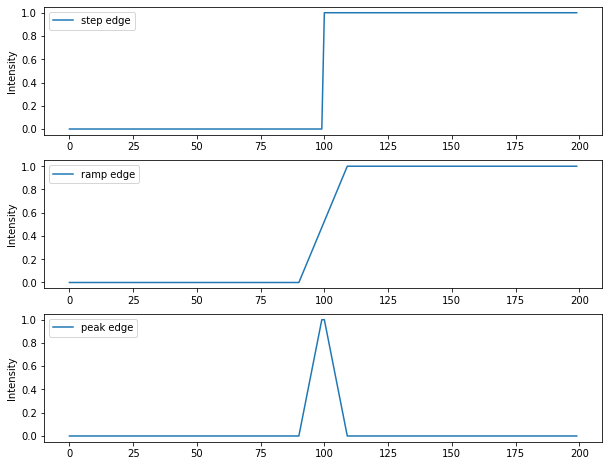

In [5]:
from matplotlib import pyplot as plt
import numpy as np 
y = np.zeros((3, 200)) 
y[0] = np.concatenate((np.zeros(100),np.ones(100))) # step edge
y[1] = np.concatenate((np.zeros(90), np.linspace(0,1,20), np.ones(90))) # ramp edge
y[2] = np.concatenate((np.zeros(90), np.linspace(0,1,10), np.linspace(1,0,10), np.zeros(90))) # peak edge
plt.figure(figsize = (10, 8))
for i, (f, title) in enumerate(zip(y, ('step edge', 'ramp edge', 'peak edge'))):
    plt.subplot(3,1,i+1)
    plt.plot(f)
    plt.legend([title], loc = 'upper left')
    plt.ylabel('Intensity')
plt.show()

### 梯度

梯度 (gradient) 可以用两个相邻像素的像素值相减表示.

类似地有 Roberts, Prewitt, Sobel 算子, 是邻近的一些像素值相减的平均.

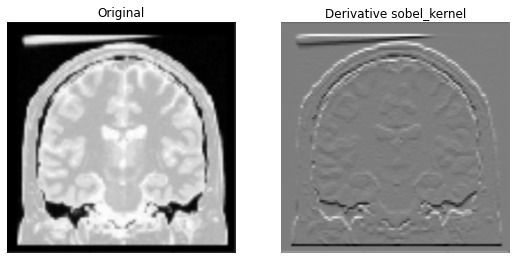

In [35]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

kernels = {
    'derv_kernel'   : np.array([[0,0,0],[0,-1.,1.],[0,0,0]]),
    'roberts_kernel': np.array([[0,0,0],[0,-1,0],[0,0,1.]]),
    'prewitt_kernel': np.array([[-1,-1,-1],[0,0,0],[1,1,1.]]),
    'sobel_kernel'  : np.array([[-1,-2,-1],[0,0,0],[1,2,1.]])
}
kernel = 'sobel_kernel'

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\brain.png')).convert('L'))
img_derv = SpatialCorrelation(img, kernels[kernel], uint8 = False)
plt.figure(figsize = (9, 5))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(img_derv, cmap = 'gray')
plt.axis('off')
plt.title('Derivative %s'%kernel)
plt.show()

### 模长

可以计算 x, y 方向的梯度 $(g_x, g_y)$, 求得模长 (magnitude) 为 $\sqrt{g_x^2+g_y^2}$.

### 法向量

可以用 2D 图像的梯度生成 3D 图像.  [Xiahai Zhuang, Lixu Gu, and Jianfeng Xu, “Medical Image Alignment 
by Normal Vector Information,” Y. Hao et al. (Eds.): CIS 2005, Part I.](https://www.docin.com/p-1442061793.html)


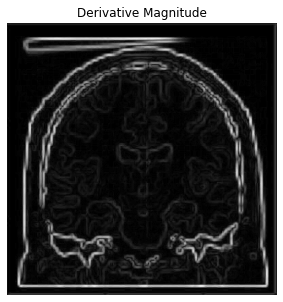

In [41]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os
dx, dy = np.array([[0,0,0],[0,-1,1.],[0,0,0]]), np.array([[0,1,0],[0,-1.,0],[0,0,0]])
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\brain.png')).convert('L'))
img_derv_magnitude = np.sqrt(np.square(SpatialCorrelation(img, dx, uint8 = False))\
                            + np.square(SpatialCorrelation(img, dy, uint8 = False)))
plt.figure(figsize = (5, 5))
plt.imshow(img_derv_magnitude, cmap = 'gray')
plt.axis('off')
plt.title('Derivative Magnitude')
plt.show()

## 锐化

常用拉普拉斯 (Laplacian) 卷积核或 Highboost. 

### 拉普拉斯卷积 

拉普拉斯卷积核是 
$$L = \left[\begin{matrix}0 & 1 & 0 \\ 1 & -4 & 1\\ 0 & 1 & 0\end{matrix}\right]\quad \Rightarrow \quad 
\Delta f = \frac{\partial ^2f}{\partial x^2}+\frac{\partial ^2f}{\partial y^2}
={\sum_{|i|=|j|=1}f(x+i,y+j)- 4f(x,y)}{}$$

用卷积核得到 $\Delta f$, 再计算 $f - w\Delta f$ ($w>0$) 即为锐化图像.

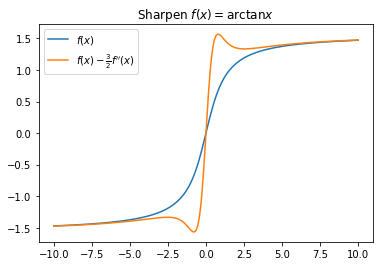

In [104]:
from matplotlib import pyplot as plt 
import numpy as np 

x = np.linspace(-10, 10, 200)
f = np.arctan(x)
ddf = - 2*x / (1+x*x)**2   # second derivative of arctan(x)
plt.plot(x, f)
plt.plot(x, f - 1.5 * ddf)
plt.legend(['$f(x)$','$f(x) - \\frac{3}{2} f\'\'(x)$'])
plt.title('Sharpen $f(x) = \\arctan x$')
plt.show()

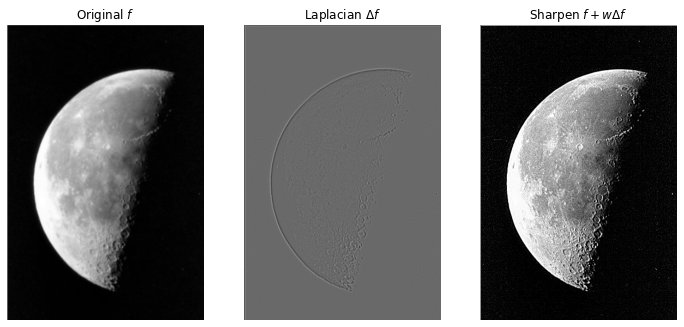

In [91]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

laplacian_kernel = np.array([[0,1,0],[1,-4.,1],[0,1,0]])
img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\moon.png')).convert('L'))
img_laplacian = Convolution(img, laplacian_kernel, uint8 = False)
img_laplacian_sharp = (img - 3 * img_laplacian).clip(0,255) # we shall use clip!!
plt.figure(figsize = (12, 9))
plt.subplot(1,3,1)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('Original $f$')
plt.subplot(1,3,2)
plt.imshow(img_laplacian, cmap = 'gray')
plt.axis('off')
plt.title('Laplacian $\\Delta f$')
plt.subplot(1,3,3)
plt.imshow(img_laplacian_sharp, cmap = 'gray')
plt.axis('off')
plt.title('Sharpen $f-w\\Delta f$')
plt.show()

### Highboost

先平滑图像得到 $\bar f$, 然后计算 $f + w(f - \bar f)$ 得到锐化图像 (即远离平滑).

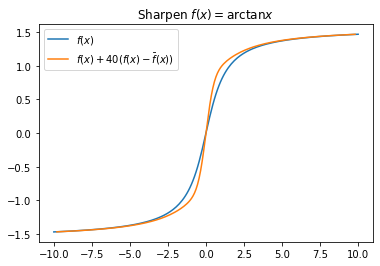

In [119]:
from matplotlib import pyplot as plt 
import numpy as np 

x = np.linspace(-10, 10, 200)
f = np.arctan(x)
avg_f = np.convolve(f, np.ones(5)/5, mode = 'valid') # average by filtering
plt.plot(x, f)
plt.plot(x[2:-2], f[2:-2] + 40 * (f[2:-2] - avg_f))
plt.legend(['$f(x)$','$f(x) + 40(f(x) - \\bar{f}(x))$'])
plt.title('Sharpen $f(x) = \\arctan x$')
plt.show()

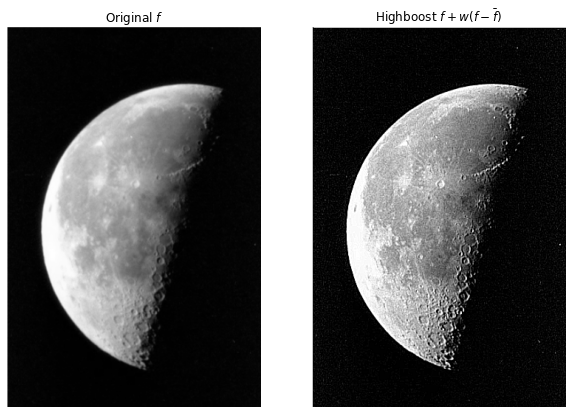

In [123]:
from matplotlib import pyplot as plt 
import numpy as np 
from PIL import Image 
import os

img = np.array(Image.open(os.path.join(os.getcwd(), 'pics\\moon.png')).convert('L'))
img_avg = Convolution(img, np.full((3,3),1. / 9), uint8 = False)
img_highboost = (img + 10 * (img - img_avg)).clip(0,255) # we shall use clip!!
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.title('Original $f$')
plt.subplot(1,2,2)
plt.imshow(img_highboost, cmap = 'gray')
plt.axis('off')
plt.title('Highboost $f + w(f - \\bar{f})$')
plt.show()